In [33]:
%%capture
%pip install numpy
!pip install torch
%pip install pandas
%pip install matplotlib

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader

In [35]:
full_dataset = pd.read_csv('./titanic/train.csv')

# Preprocess the data
y = full_dataset['Survived']
X_unprocessed = full_dataset[['Pclass', 'Sex', 'SibSp', 'Parch', 'Age', 'Fare', 'Embarked']].copy()

# Fill missing values
X_unprocessed['Fare'] = X_unprocessed['Fare'].fillna(X_unprocessed['Fare'].median())
X_unprocessed['Age'] = X_unprocessed['Age'].fillna(X_unprocessed['Age'].median())
X_unprocessed['Embarked'] = X_unprocessed['Embarked'].fillna(X_unprocessed['Embarked'].mode()[0])

# Standardize numerical columns
num_cols = ['Age', 'Fare', 'SibSp', 'Parch']
X_unprocessed[num_cols] = (X_unprocessed[num_cols] - X_unprocessed[num_cols].mean()) / X_unprocessed[num_cols].std()

# One-hot encode categorical columns
X = pd.get_dummies(X_unprocessed).astype(float)

X = torch.tensor(X.values).float()
y = torch.tensor(y).long()


In [36]:

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size 


seed = torch.Generator().manual_seed(49)
train_dataset, test_dataset= random_split(torch.utils.data.TensorDataset(X,y), [train_size, test_size], generator=seed)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_dim = X.shape[1]
y_train_t = y[train_dataset.indices]
num_classes = len(torch.unique(y_train_t))


In [37]:
def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    for X, y in loader:
        outputs = model(X)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total

In [38]:
def train_model(model, train_loader, test_loader, opt, epochs=100):
    loss_fn = torch.nn.CrossEntropyLoss()
    lr = 1e-2
    
    train_acc_array = []

    test_acc_array = []

    #opt = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.001)

    for epoch in range(epochs):
        model.train()

        for X_train, y_train in train_loader:
            opt.zero_grad()
            z = model(X_train) 
            loss = loss_fn(z,y_train) 
            loss.backward() 
            opt.step() 

        train_acc = accuracy(model, train_loader)

        train_acc_array.append(train_acc)

        test_acc = accuracy(model, test_loader)

        test_acc_array.append(test_acc)

        print(f"Epoch: {epoch+1}")
        print(f"Loss: {loss.item():.4f} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}\n")

    plt.xlabel("Epoch")

    plt.ylabel("Accuracy")
    
    plt.plot(range(1, 101), train_acc_array)

    plt.plot(range(1, 101), test_acc_array)
       

Epoch: 1
Loss: 0.5547 | Train Accuracy: 0.6208 | Test Accuracy: 0.6257

Epoch: 2
Loss: 0.8593 | Train Accuracy: 0.6264 | Test Accuracy: 0.6257

Epoch: 3
Loss: 0.5592 | Train Accuracy: 0.6376 | Test Accuracy: 0.6257

Epoch: 4
Loss: 0.5680 | Train Accuracy: 0.6447 | Test Accuracy: 0.6425

Epoch: 5
Loss: 0.8781 | Train Accuracy: 0.6517 | Test Accuracy: 0.6592

Epoch: 6
Loss: 0.7762 | Train Accuracy: 0.6573 | Test Accuracy: 0.6480

Epoch: 7
Loss: 0.6365 | Train Accuracy: 0.6629 | Test Accuracy: 0.6648

Epoch: 8
Loss: 0.5994 | Train Accuracy: 0.6812 | Test Accuracy: 0.6760

Epoch: 9
Loss: 0.4182 | Train Accuracy: 0.6826 | Test Accuracy: 0.6816

Epoch: 10
Loss: 0.6022 | Train Accuracy: 0.6896 | Test Accuracy: 0.6927

Epoch: 11
Loss: 0.8825 | Train Accuracy: 0.7065 | Test Accuracy: 0.7207

Epoch: 12
Loss: 0.5346 | Train Accuracy: 0.6952 | Test Accuracy: 0.7207

Epoch: 13
Loss: 0.7404 | Train Accuracy: 0.7135 | Test Accuracy: 0.7207

Epoch: 14
Loss: 0.4735 | Train Accuracy: 0.7149 | Test Accur

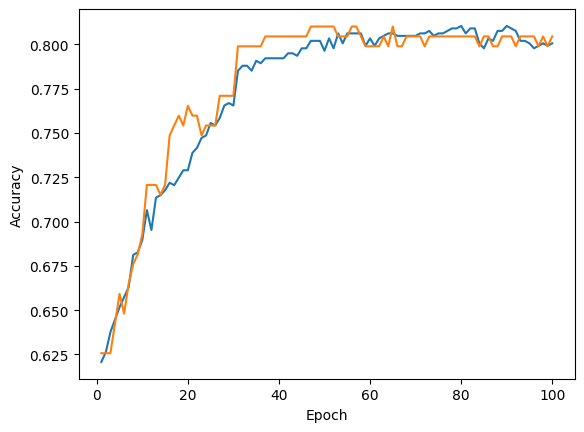

In [39]:
linear_model = torch.nn.Linear(input_dim, num_classes)

sdg_opt = torch.optim.SGD(linear_model.parameters(), lr=1e-2)

train_model(linear_model, train_loader, test_loader, sdg_opt)

Define a Model

We chose to define a simple Neural Network with three layers and one hidden layer of size 100.

In [40]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

No Optimization

Epoch: 1
Loss: 0.7287 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 2
Loss: 0.7128 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 3
Loss: 0.6877 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 4
Loss: 0.6260 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 5
Loss: 0.7367 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 6
Loss: 0.6785 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 7
Loss: 0.5758 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 8
Loss: 0.5760 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 9
Loss: 0.7628 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 10
Loss: 0.5959 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 11
Loss: 0.5715 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 12
Loss: 0.6271 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 13
Loss: 0.6311 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 14
Loss: 0.5912 | Train Accuracy: 0.6138 | Test Accur

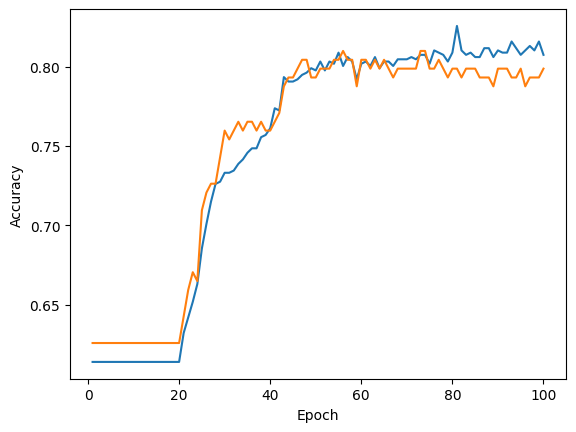

In [41]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2)

train_model(nn_model, train_loader, test_loader, sdg_opt)

Regularization

Epoch: 1
Loss: 0.6742 | Train Accuracy: 0.6025 | Test Accuracy: 0.6145

Epoch: 2
Loss: 0.7125 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 3
Loss: 0.6717 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 4
Loss: 0.6662 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 5
Loss: 0.6680 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 6
Loss: 0.5786 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 7
Loss: 0.7005 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 8
Loss: 0.7008 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 9
Loss: 0.5897 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 10
Loss: 0.5909 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 11
Loss: 0.6184 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 12
Loss: 0.7849 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 13
Loss: 0.7865 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 14
Loss: 0.5979 | Train Accuracy: 0.6138 | Test Accur

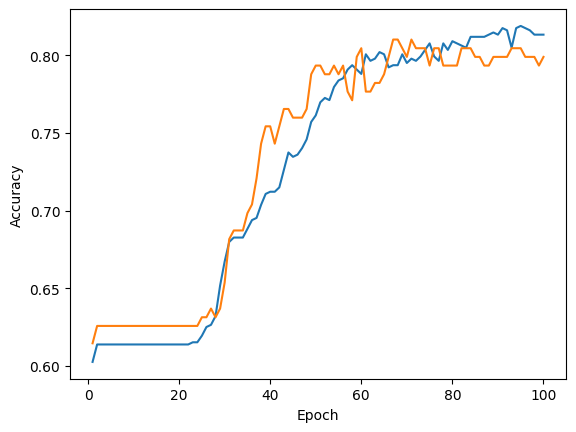

In [42]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=0.001)

train_model(nn_model, train_loader, test_loader, sdg_opt)

Epoch: 1
Loss: 0.6898 | Train Accuracy: 0.4452 | Test Accuracy: 0.4190

Epoch: 2
Loss: 0.6803 | Train Accuracy: 0.6222 | Test Accuracy: 0.6425

Epoch: 3
Loss: 0.6522 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 4
Loss: 0.7097 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 5
Loss: 0.6201 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 6
Loss: 0.6782 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 7
Loss: 0.6186 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 8
Loss: 0.5359 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 9
Loss: 0.7814 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 10
Loss: 0.6779 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 11
Loss: 0.4643 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 12
Loss: 0.5744 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 13
Loss: 0.5734 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 14
Loss: 0.5479 | Train Accuracy: 0.6138 | Test Accur

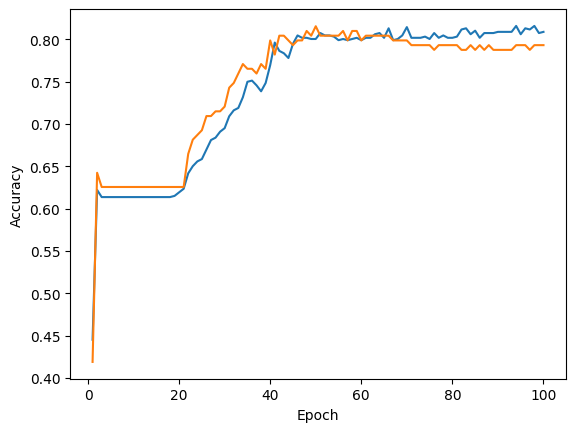

In [43]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=0.01)

train_model(nn_model, train_loader, test_loader, sdg_opt)

Epoch: 1
Loss: 0.6423 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 2
Loss: 0.6893 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 3
Loss: 0.6307 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 4
Loss: 0.6813 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 5
Loss: 0.6607 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 6
Loss: 0.6013 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 7
Loss: 0.7035 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 8
Loss: 0.6368 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 9
Loss: 0.7033 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 10
Loss: 0.7089 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 11
Loss: 0.6569 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 12
Loss: 0.6053 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 13
Loss: 0.5250 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 14
Loss: 0.6678 | Train Accuracy: 0.6138 | Test Accur

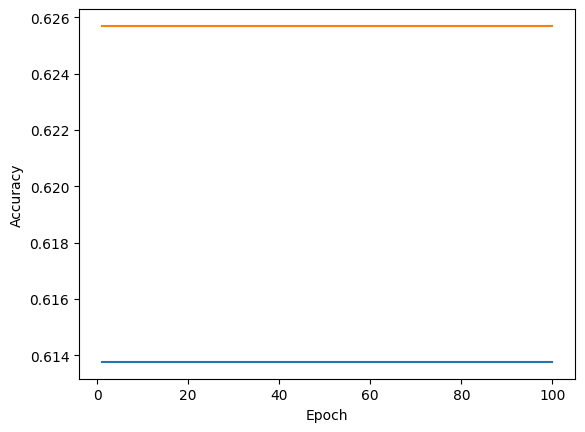

In [44]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=0.1)

train_model(nn_model, train_loader, test_loader, sdg_opt)

Epoch: 1
Loss: 0.6830 | Train Accuracy: 0.3862 | Test Accuracy: 0.3743

Epoch: 2
Loss: 0.6926 | Train Accuracy: 0.3862 | Test Accuracy: 0.3743

Epoch: 3
Loss: 0.6928 | Train Accuracy: 0.6671 | Test Accuracy: 0.6369

Epoch: 4
Loss: 0.6954 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 5
Loss: 0.6866 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 6
Loss: 0.6926 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 7
Loss: 0.6935 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 8
Loss: 0.7046 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 9
Loss: 0.6941 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 10
Loss: 0.6443 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 11
Loss: 0.6947 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 12
Loss: 0.6503 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 13
Loss: 0.6791 | Train Accuracy: 0.6138 | Test Accuracy: 0.6257

Epoch: 14
Loss: 0.6953 | Train Accuracy: 0.6138 | Test Accur

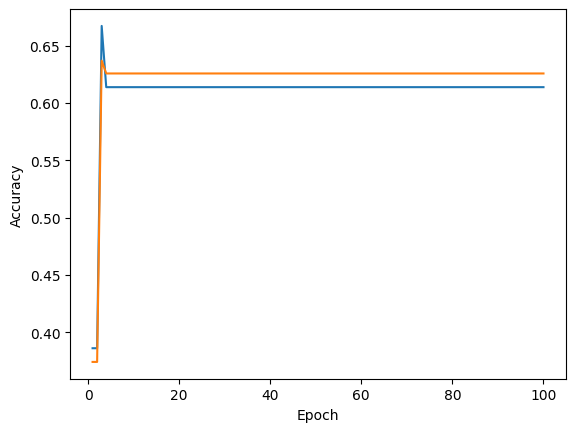

In [45]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

sdg_opt = torch.optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1)

train_model(nn_model, train_loader, test_loader, sdg_opt)

The model without weight decay performed well and did not overfit to the data. Adding regularization to the model is therefore not necessary. Adding small amounts of weight decay did not seem to affect the model while large values of weight decay worsened the model.

Epoch: 1
Loss: 0.6948 | Train Accuracy: 0.7865 | Test Accuracy: 0.7933

Epoch: 2
Loss: 0.2436 | Train Accuracy: 0.8132 | Test Accuracy: 0.8101

Epoch: 3
Loss: 0.4054 | Train Accuracy: 0.8202 | Test Accuracy: 0.8101

Epoch: 4
Loss: 0.2281 | Train Accuracy: 0.8343 | Test Accuracy: 0.8268

Epoch: 5
Loss: 0.1579 | Train Accuracy: 0.8258 | Test Accuracy: 0.7877

Epoch: 6
Loss: 0.2457 | Train Accuracy: 0.8427 | Test Accuracy: 0.7933

Epoch: 7
Loss: 0.3151 | Train Accuracy: 0.8497 | Test Accuracy: 0.7933

Epoch: 8
Loss: 0.3086 | Train Accuracy: 0.8385 | Test Accuracy: 0.8268

Epoch: 9
Loss: 0.4978 | Train Accuracy: 0.8511 | Test Accuracy: 0.7933

Epoch: 10
Loss: 0.7874 | Train Accuracy: 0.8539 | Test Accuracy: 0.7989

Epoch: 11
Loss: 0.5347 | Train Accuracy: 0.8539 | Test Accuracy: 0.8268

Epoch: 12
Loss: 0.2838 | Train Accuracy: 0.8385 | Test Accuracy: 0.8380

Epoch: 13
Loss: 0.3376 | Train Accuracy: 0.8525 | Test Accuracy: 0.8156

Epoch: 14
Loss: 0.1370 | Train Accuracy: 0.8441 | Test Accur

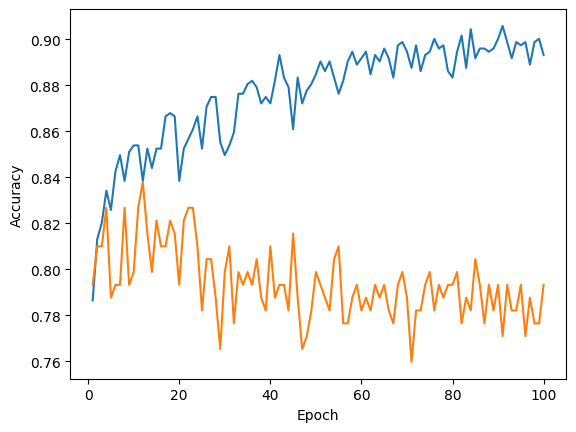

In [46]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, num_classes)
)

adam_opt = torch.optim.Adam(nn_model.parameters(), lr=1e-2)

train_model(nn_model, train_loader, test_loader, adam_opt)